## Assumptions & Hypotheses — what influences `is_delayed`? 🔎

**Goal:** State clear, testable assumptions about which features drive the binary label `is_delayed`.

- **`distance_km`** — *Primary hypothesis (positive)*: Longer distances increase probability of being delayed. Expected to dominate signal.
- **`same_zone`** — *Protective (negative)*: Orders where user and rider are in the same zone are less likely to be delayed (shorter pickup/travel time).
- **`zone_load_rolling`** — *Positive*: Higher recent delay rate in a user zone indicates local congestion/load, increasing delay risk.
- **`order_hour` / `order_dow`** — *Contextual (varied)*: Peak hours (lunch/dinner) and specific days may increase delay probability; expect non-linear/cyclical effects.
- **`avg_rider_rating_hist`** — *Negative*: Higher-rated riders may be faster/more reliable, reducing delays.
- **`user_zone` / `rider_zone`** — *Location-specific effects*: Some zones may systematically have more delays due to distance, traffic, or infrastructure.
- **`is_weekend`** — *Ambiguous*: Weekends can increase demand (positive) or reduce traffic (negative); direction must be verified.

### Diagnostic tests & experiments ✅

1. **Feature importance & coefficients**: Inspect logistic regression coefficients (odds ratios) and absolute magnitude — confirm if `distance_km` dominates.
2. **Ablation study**: Refit models excluding `distance_km` and measure drop in ROC AUC to quantify its contribution.
3. **Partial dependence / SHAP**: Visualize marginal effect of `distance_km`, `same_zone`, and `zone_load_rolling` to validate shape and thresholds.
4. **Interaction checks**: Test interactions (e.g., `distance_km * same_zone`, `distance_km * order_hour`) for non-additive effects.
5. **Subgroup analysis & calibration**: Evaluate model performance and calibration across distance quantiles and by `user_zone`.
6. **Target reframing**: Consider regression on `delivery_time` (or residuals after removing distance effect) to capture richer dynamics.


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

# Transformers
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sqlalchemy import create_engine

# หาค่าโฟลเดอร์ปัจจุบัน
PATH = Path.cwd()

load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL")

engine = create_engine(DATABASE_URL)


In [2]:
query = """
select
    order_ts,
    delivery_time,
    distance_km,
    order_hour,
    order_dow,
    avg_rider_rating_hist,
    user_zone,
    rider_zone
from public.fct_delivery_time
where avg_rider_rating_hist is not null
order by order_ts
"""

df = pd.read_sql(query, engine)

# sort by order_ts
df.sort_values("order_ts", inplace=True)

# delayed based on mean delivery time
df["is_delayed"] = (df["delivery_time"] > df["delivery_time"].mean()).astype(int)

print(f"na contain in cols :\n {df.isna().sum()}")

num_cols = ["distance_km", "order_hour", "order_dow", "avg_rider_rating_hist"]
cat_cols = ["user_zone", "rider_zone"]
target_col = "is_delayed"

na contain in cols :
 order_ts                 0
delivery_time            0
distance_km              0
order_hour               0
order_dow                0
avg_rider_rating_hist    0
user_zone                0
rider_zone               0
is_delayed               0
dtype: int64


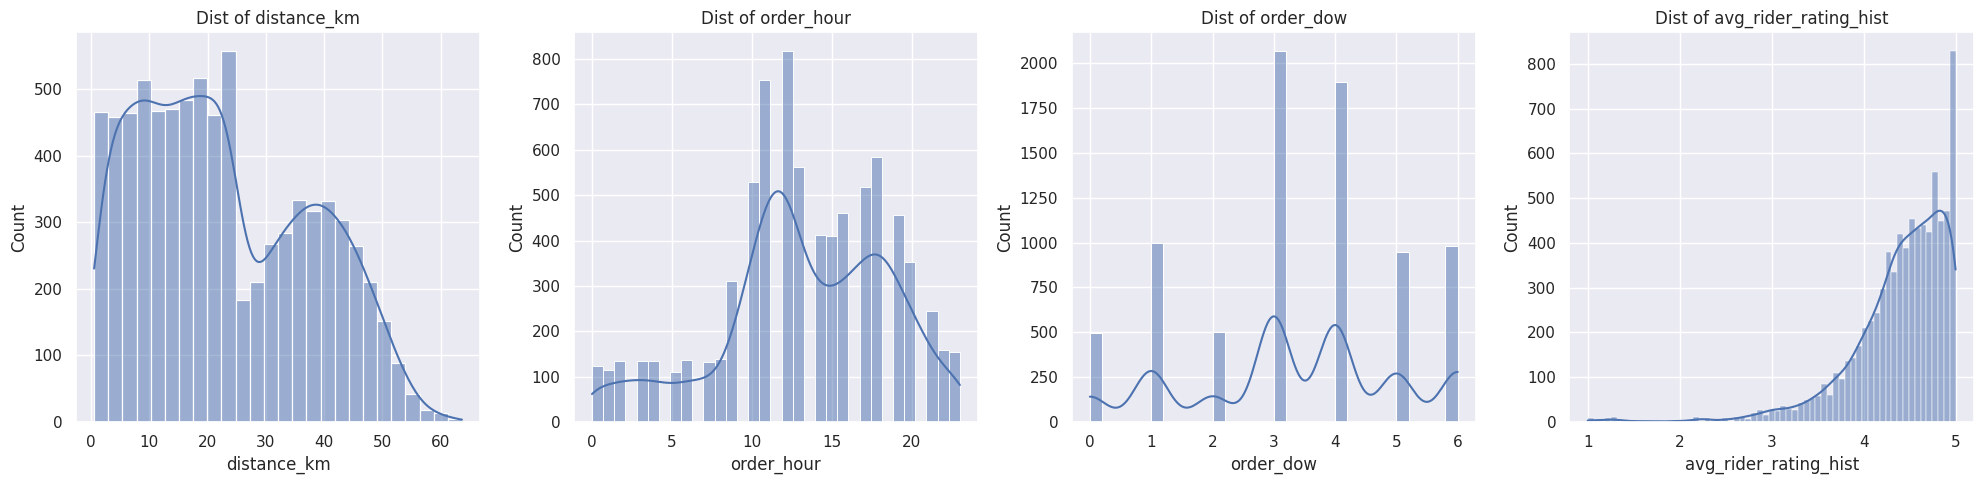

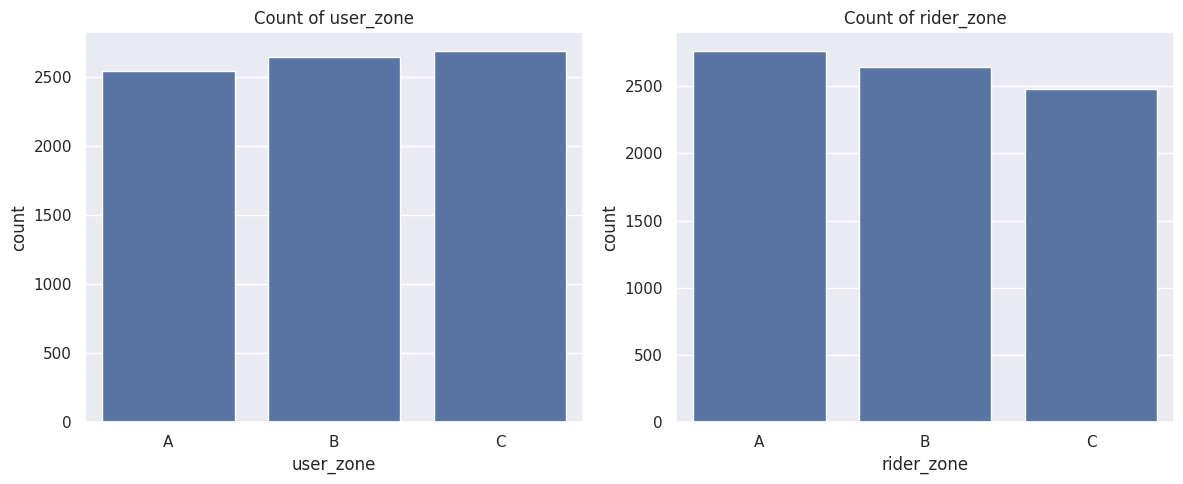

In [3]:
# EDA visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# num
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Dist of {col}")

plt.tight_layout()
plt.show()


# cat
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Count of {col}")

plt.tight_layout()
plt.show()

# Number cols

**distance_km** 
- have two cluster at ~15km and 40km
- guassian mixture distribution

**order_hour**
- also have two clusters at launch and dinner time
- guassian mixture distribution
**order_dow**
- is discrete where 0 is sunday 
- shouldnt use as number cols but cat instead so the model wont penalize and mis interpret the numbers

**avg_rider_rating_hist**
- severe imbalanced of data where mean is around +4 rating
- we should do log-transform


# Cat cols

**user_zone & rider_zone**
- not perfectly balanced
- where users live more in zone C while riders live more in zone A

Average distance for same zone: 12.621736348122868
Average distance for diffrence zone: 38.00826087589011


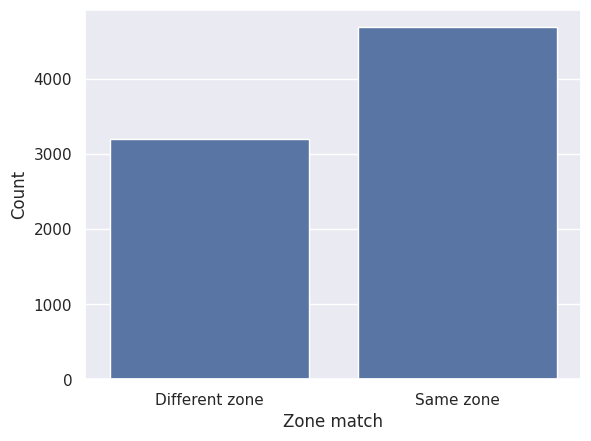

na contain in cols :
 order_ts                 0
delivery_time            0
distance_km              0
order_hour               0
order_dow                0
avg_rider_rating_hist    0
user_zone                0
rider_zone               0
is_delayed               0
same_zone                0
hour_sin                 0
hour_cos                 0
dow_sin                  0
dow_cos                  0
is_weekend               0
zone_load_rolling        0
dtype: int64


In [4]:
# feature engineering

df.sort_values("order_ts", inplace=True)  # sort again to ensure

df["same_zone"] = (df["user_zone"] == df["rider_zone"]).astype(int)
# 1 for same zone, 0 for different zone

avg_km_same_zone = df[df["same_zone"] == 1]["distance_km"].mean()
avg_km_diff_zone = df[df["same_zone"] == 0]["distance_km"].mean()

print(f"Average distance for same zone: {avg_km_same_zone}")
print(f"Average distance for diffrence zone: {avg_km_diff_zone}")


# cyclical encoding for order_hour and order_dow
# using both sine and cosine to prevent the zero amplitude issue
df["hour_sin"] = np.sin(2 * np.pi * df["order_hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["order_hour"] / 24)

df["dow_sin"] = np.sin(2 * np.pi * df["order_dow"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["order_dow"] / 7)

df["is_weekend"] = df["order_dow"].apply(lambda x: 1 if x in [0, 6] else 0)


# rolling average of is_delayed per user_zone
# exclude current row preveting data leakage
df["zone_load_rolling"] = df.groupby("user_zone")["is_delayed"].transform(
    lambda x: x.rolling(window=5, closed="left").mean()
)
# fill first few na with overall mean
df["zone_load_rolling"] = df["zone_load_rolling"].fillna(df["is_delayed"].mean())


sns.countplot(x="same_zone", data=df)
plt.xticks([0, 1], ["Different zone", "Same zone"])
plt.xlabel("Zone match")
plt.ylabel("Count")
plt.show()

print(f"na contain in cols :\n {df.isna().sum()}")

In [12]:
df["order_dow"].unique()

array([3., 4., 5., 6., 0., 1., 2.])

# Insights

**feature engineer : zone match**
- after doing zone match feature we found that rider tends to accept order in their same zone than diffrence zone
- distance in same zone is much shorter than diffrence zone (12.6 vs 38)



In [35]:
# move order_dow to cat_cols
num_cols = [
    "distance_km",
    "order_hour",
    "avg_rider_rating_hist",
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
    "zone_load_rolling",
]
cat_cols = ["user_zone", "rider_zone", "order_dow", "same_zone", "is_weekend"]
target_col = "is_delayed"


user_zones = sorted(df["user_zone"].astype(str).unique().tolist())
rider_zones = sorted(df["rider_zone"].astype(str).unique().tolist())
dow_categories = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
same_zone_vals = sorted(df["same_zone"].unique().tolist())
is_weekend_vals = sorted(df["is_weekend"].unique().tolist())

categories_list = [
    user_zones,  # user_zone
    rider_zones,  # rider_zone
    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],  # order_dow
    same_zone_vals,  # same_zone
    is_weekend_vals,  # is_weekend
]


preprocess = ColumnTransformer(
    [
        ("num", PowerTransformer(), num_cols),
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                drop="first",
                categories=categories_list,
            ),
            cat_cols,
        ),
    ]
)

model = LogisticRegression(
    max_iter=5000, solver="saga", random_state=42
)  # saga for hypertuning regulator
scores = []

param_grid = [
    {
        "model__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        "model__l1_ratio": [0, 0.25, 0.5, 0.75, 1],
    }
]

pipe = Pipeline([("prep", preprocess), ("model", model)])

tss = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)

grid = GridSearchCV(
    pipe, param_grid, cv=tss, scoring="roc_auc", return_train_score=True
)
grid.fit(df[num_cols + cat_cols], df["is_delayed"])


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...ver='saga'))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model__C': [0.001, 0.01, ...], 'model__l1_ratio': [0, 0.25, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",TimeSeriesSpl...est_size=None)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is disp

In [36]:
cv_result = pd.DataFrame(grid.cv_results_)
cv_result.to_csv(os.path.join(PATH, "cv_result.csv"))
print(f"CV results saved to {os.path.join(PATH, 'cv_result.csv')}")

print(f"Best Params: {grid.best_params_}")
print(f"Best Accuracy: {grid.best_score_:.4f}")


def show_feat_important(grid, top_k=None):
    best_pipe = grid.best_estimator_
    model = best_pipe.named_steps["model"]
    feature_names = best_pipe.named_steps["prep"].get_feature_names_out()
    weights = model.coef_.ravel()

    feats = list(zip(feature_names, weights))
    feats.sort(key=lambda x: abs(x[1]), reverse=True)

    if top_k:
        feats = feats[:top_k]

    for name, weight in feats:
        print(f"{name:30} : {weight:+.4f}")


show_feat_important(grid)

CV results saved to /home/kheaw/projects/food-delivery-data-platform/models/delivery_time_classification/cv_result.csv
Best Params: {'model__C': 0.1, 'model__l1_ratio': 0.75}
Best Accuracy: 0.9646
num__distance_km               : +4.1612
num__zone_load_rolling         : +0.3764
num__hour_sin                  : -0.3420
num__hour_cos                  : +0.2541
cat__rider_zone_C              : -0.0584
cat__user_zone_C               : -0.0538
num__avg_rider_rating_hist     : -0.0238
num__order_hour                : -0.0165
num__dow_cos                   : -0.0010
cat__same_zone_1               : -0.0003
num__dow_sin                   : +0.0002
cat__user_zone_B               : +0.0000
cat__rider_zone_B              : +0.0000
cat__order_dow_1.0             : +0.0000
cat__order_dow_2.0             : +0.0000
cat__order_dow_3.0             : +0.0000
cat__order_dow_4.0             : +0.0000
cat__order_dow_5.0             : +0.0000
cat__order_dow_6.0             : +0.0000
cat__is_weekend_1       

In [37]:
from sklearn.model_selection import cross_validate

# 1. Simple Preprocessing for Baseline (No PowerTransformer, No Sin/Cos)
baseline_preprocess = ColumnTransformer(
    [
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            ["user_zone", "rider_zone", "order_dow"],
        )
    ],
    remainder="passthrough",
)

# 2. Simple Model (No tuning, default C=1.0)
baseline_pipe = Pipeline(
    [
        ("prep", baseline_preprocess),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

# 3. Run cross-validation
baseline_results = cross_validate(
    baseline_pipe, df[num_cols + cat_cols], df["is_delayed"], cv=tss, scoring="roc_auc"
)

baseline_roc_auc = baseline_results["test_score"].mean()

print("--- The Real Comparison ---")
print(f"Simple Logistic Baseline ROC-AUC: {baseline_roc_auc:.4f}")
print(f"Tuned & Engineered ROC-AUC:     {grid.best_score_:.4f}")
print(f"Net Lift:                       {grid.best_score_ - baseline_roc_auc:.4f}")

--- The Real Comparison ---
Simple Logistic Baseline ROC-AUC: 0.9633
Tuned & Engineered ROC-AUC:     0.9646
Net Lift:                       0.0014


In [38]:
num_cols_no_dist = [col for col in num_cols if col != "distance_km"]

print('\n--- Ablation test: Removing "distance_km" feature ---')

preprocess_no_dist = ColumnTransformer(
    [
        ("num", PowerTransformer(), num_cols_no_dist),
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore", drop="first", categories=categories_list
            ),
            cat_cols,
        ),
    ]
)

pipe_no_dist = Pipeline([("prep", preprocess_no_dist), ("model", model)])
grid_no_dist = GridSearchCV(pipe_no_dist, param_grid, cv=tss, scoring="roc_auc")

grid_no_dist.fit(df[num_cols_no_dist + cat_cols], df["is_delayed"])


print('\n--- Ablation test: Using ONLY "distance_km" feature ---')

preprocess_only_dist = ColumnTransformer([("num", PowerTransformer(), ["distance_km"])])

pipe_only_dist = Pipeline([("prep", preprocess_only_dist), ("model", model)])

grid_only_dist = GridSearchCV(pipe_only_dist, param_grid, cv=tss, scoring="roc_auc")

grid_only_dist.fit(df[["distance_km"]], df["is_delayed"])



--- Ablation test: Removing "distance_km" feature ---

--- Ablation test: Using ONLY "distance_km" feature ---


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...ver='saga'))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model__C': [0.001, 0.01, ...], 'model__l1_ratio': [0, 0.25, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",TimeSeriesSpl...est_size=None)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is disp

In [39]:
print(f"Best ROC-AUC (No Distance): {grid_no_dist.best_score_:.4f}")
show_feat_important(grid_no_dist)

print()
print(f"Best ROC-AUC (Only Distance): {grid_only_dist.best_score_:.4f}")
show_feat_important(grid_only_dist)

Best ROC-AUC (No Distance): 0.9055
cat__same_zone_1               : -4.1087
num__hour_sin                  : -0.3161
num__zone_load_rolling         : +0.2742
num__hour_cos                  : +0.1549
num__order_hour                : -0.0719
cat__rider_zone_C              : -0.0669
cat__rider_zone_B              : -0.0339
num__avg_rider_rating_hist     : -0.0034
num__dow_sin                   : -0.0015
num__dow_cos                   : -0.0009
cat__user_zone_B               : +0.0000
cat__user_zone_C               : +0.0000
cat__order_dow_1.0             : +0.0000
cat__order_dow_2.0             : +0.0000
cat__order_dow_3.0             : +0.0000
cat__order_dow_4.0             : +0.0000
cat__order_dow_5.0             : +0.0000
cat__order_dow_6.0             : +0.0000
cat__is_weekend_1              : +0.0000

Best ROC-AUC (Only Distance): 0.9594
num__distance_km               : +1.1703


## Ablation Test Summary

### ROC–AUC Comparison
- **No Distance Features:** `0.9055`
- **Only Distance Feature:** `0.9594`

> Distance alone outperforms the full feature set without distance, indicating it is the **dominant predictive signal**.
 

## Feature Importance — No Distance Model
*(Logistic Regression coefficients, ordered by |weight|)*

### High Impact Features
- **`cat__same_zone_1` (-4.1087)**  
  Strong negative effect. Orders in the same zone are significantly less likely for the positive class.

- **`num__hour_sin` (-0.3161)**  
  Time-of-day cyclic effect. Certain hours reduce likelihood.

- **`num__zone_load_rolling` (+0.2742)**  
  Higher recent zone load increases likelihood.

- **`num__hour_cos` (+0.1549)**  
  Complementary cyclic time signal.
 

### Medium Impact Features
- `num__order_hour` (-0.0719)
- `cat__rider_zone_C` (-0.0669)
- `cat__rider_zone_B` (-0.0339)

These contribute marginally compared to top drivers.
 

### Low / Negligible Impact
- Rider rating history
- Day-of-week sine/cosine
- User zone
- Weekend flag
- One-hot encoded weekdays

> Coefficients ≈ 0 indicate little to no linear signal after regularization.
 

## Feature Importance — Distance-Only Model

### Dominant Feature
- **`num__distance_km` (+1.1703)**  

Distance alone provides strong separation, explaining the superior ROC–AUC.
 

## Conclusion 
- **Distance is the strongest predictor**
- Without distance, model relies heavily on **zone alignment** and **time patterns**
- Many categorical features are effectively pruned by regularization
- Suggestion: combine distance with top non-distance features for optimal performance


Additionally, we do SHapley Additive exPlanations to see how each feature contributes to model

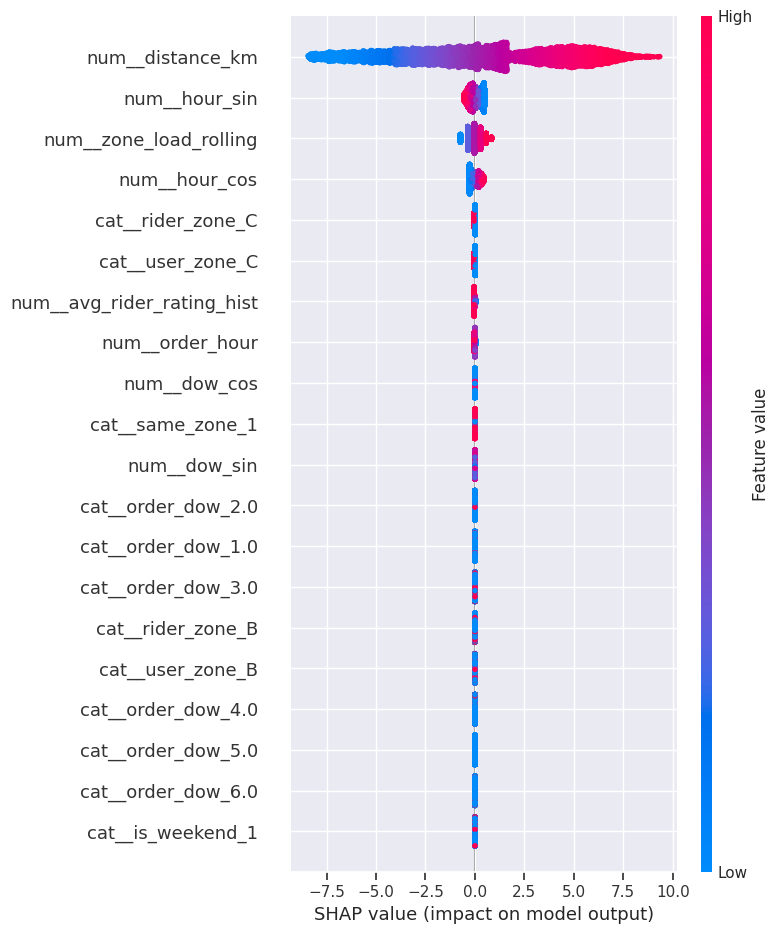

In [40]:
import shap

best_pipe = grid.best_estimator_
best_model = best_pipe.named_steps["model"]
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()


X_transformed = best_pipe.named_steps["prep"].transform(df[num_cols + cat_cols])

# 2. Explain the model's predictions
explainer = shap.Explainer(best_model, X_transformed, feature_names=feature_names)
shap_values = explainer(X_transformed)

# 3. Plot it
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

**fun facts** : SHAP handles `num__hour_sin` and `num__hour_cos` perfectly by letting both contributions to model **almost reverse identical**

---


## Final verdict — `is_delayed` is largely a distance signal

- **Summary:** The classification target **`is_delayed`** is dominated by **`distance_km`**; However , **others feature still important** since the albation test told us that non-distance features signals if the delivery time is above average

**Problem with is_delay**
- we calculated is_delay by finding which delivery time is above mean, when using **`distance_km`** is too predictive even eyeballing to data is enough.

🕺 *Good sides* is combinding other features still improve classification in some cases like same distance but diffrence time and zone

- **Recommendations:**
  - Consider predicting **`delivery_time`** (regression) instead, or add richer contextual features (traffic, weather, order complexity).
  - If keeping classification, binning distance or adding interaction terms may reduce single-feature dominance.

